In [24]:
###### Config #####
import sys, os, platform
if os.path.isdir("ds-assets"):
  !cd ds-assets && git pull
else:
  !git clone https://github.com/lutzhamel/ds-assets.git
colab = True if 'google.colab' in os.sys.modules else False
system = platform.system() # "Windows", "Linux", "Darwin"
home = "ds-assets/assets/"
sys.path.append(home)

Already up to date.


In [85]:
import pandas as pd
import dsutils
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

Load our data and convert it to a Pandas time series dataframe.

In [26]:
# air passenger data
air = pd.read_csv(home+'AirPassengers.csv')
air.columns = ['date','passengers'] # rename columns for convenience
air.index = pd.DatetimeIndex(air['date']) # create a time index
air.drop(columns=['date'], inplace=True)
air.head()

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Text(0, 0.5, 'Number of Passengers')

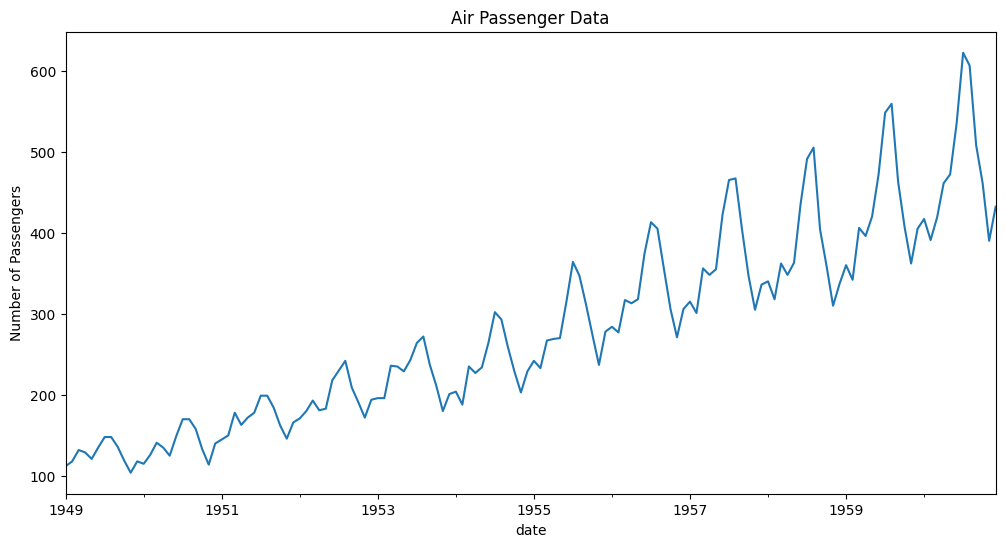

In [27]:
air.plot(figsize=(12,6), title='Air Passenger Data', legend=False)\
      .set_ylabel('Number of Passengers')

# Modeling

[source](https://www.nbshare.io/notebook/136553745/Time-Series-Analysis-Using-ARIMA-From-StatsModels/),
[source](https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python)

This is about building models of the time series in order to predict values that are not part of the training set.

As a first step we perform seasonal decomposition.

In [32]:
decomp = seasonal_decompose(
        air['passengers'],
        model='multiplicative',
        extrapolate_trend = 6 # have to include, centered moving avg
    )

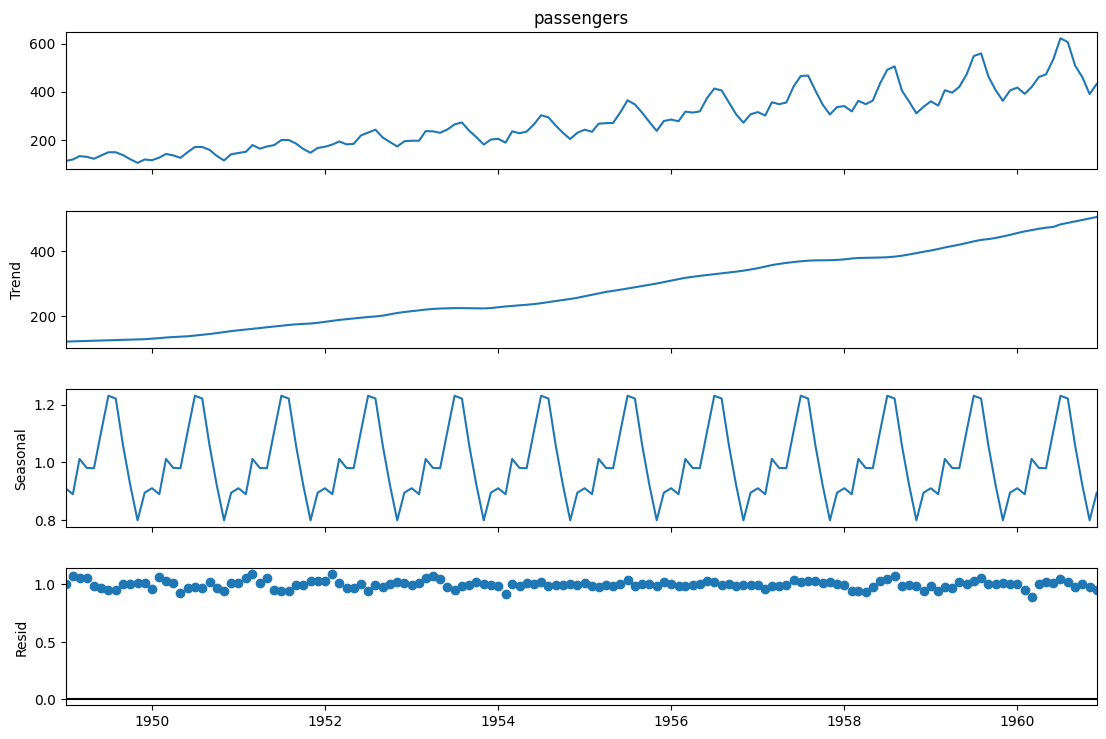

In [35]:
decomp.plot().set_size_inches(12, 8)

We can't do modeling with Pandas' DatetimeIndex objects as the independent variable.  Therefore, we create a new variable called **timedelta** which simply **counts the number of days** from the start of the model data.  That new variable will become our independent variable as a proxy for the DatetimeIndex obects.  This is often called **feature engineering**.

In [127]:
timedelta = list((air.index - air.index[0]).days) # time in days
timedelta

[0,
 31,
 59,
 90,
 120,
 151,
 181,
 212,
 243,
 273,
 304,
 334,
 365,
 396,
 424,
 455,
 485,
 516,
 546,
 577,
 608,
 638,
 669,
 699,
 730,
 761,
 789,
 820,
 850,
 881,
 911,
 942,
 973,
 1003,
 1034,
 1064,
 1095,
 1126,
 1155,
 1186,
 1216,
 1247,
 1277,
 1308,
 1339,
 1369,
 1400,
 1430,
 1461,
 1492,
 1520,
 1551,
 1581,
 1612,
 1642,
 1673,
 1704,
 1734,
 1765,
 1795,
 1826,
 1857,
 1885,
 1916,
 1946,
 1977,
 2007,
 2038,
 2069,
 2099,
 2130,
 2160,
 2191,
 2222,
 2250,
 2281,
 2311,
 2342,
 2372,
 2403,
 2434,
 2464,
 2495,
 2525,
 2556,
 2587,
 2616,
 2647,
 2677,
 2708,
 2738,
 2769,
 2800,
 2830,
 2861,
 2891,
 2922,
 2953,
 2981,
 3012,
 3042,
 3073,
 3103,
 3134,
 3165,
 3195,
 3226,
 3256,
 3287,
 3318,
 3346,
 3377,
 3407,
 3438,
 3468,
 3499,
 3530,
 3560,
 3591,
 3621,
 3652,
 3683,
 3711,
 3742,
 3772,
 3803,
 3833,
 3864,
 3895,
 3925,
 3956,
 3986,
 4017,
 4048,
 4077,
 4108,
 4138,
 4169,
 4199,
 4230,
 4261,
 4291,
 4322,
 4352]

We also create a variable called 'month' that tells us which month of the year we are currently looking at.  This will become important when we do seasonal modeling.

In [130]:
X = pd.DataFrame({'timedelta': timedelta,
                  'month': air.index.month,},
                  index=air.index)
X

,timedelta,month
date,,
1949-01-01,0,1
1949-02-01,31,2
1949-03-01,59,3
1949-04-01,90,4
1949-05-01,120,5
...,...,...
1960-08-01,4230,8
1960-09-01,4261,9
1960-10-01,4291,10


## Trend Modeling

We start with trend forecasting.  We first extract the trend information from the time series by applying the rolling window methodology.

In [128]:
air_trend = decomp.trend

Text(0, 0.5, 'Number of Passengers')

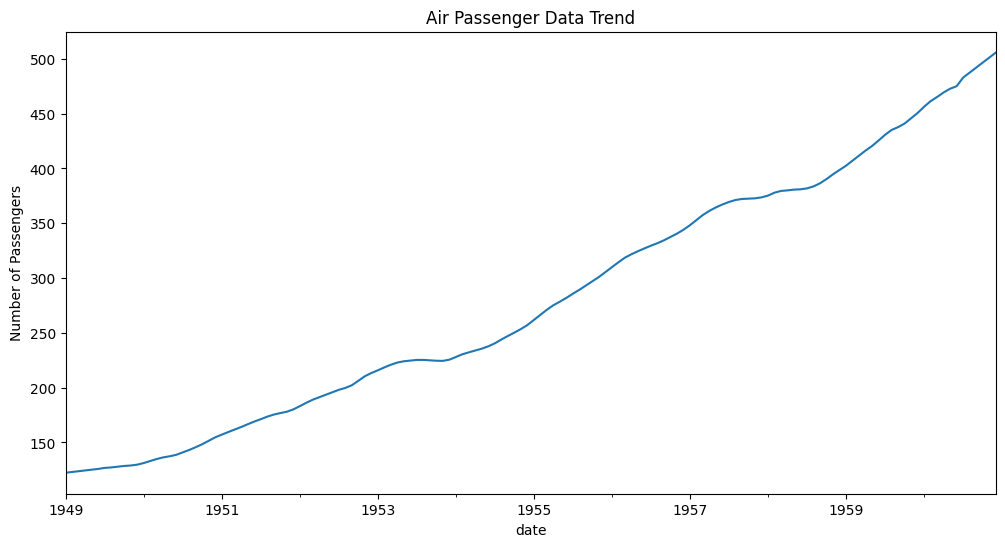

In [129]:
air_trend.plot(figsize=(12,6), title='Air Passenger Data Trend', legend=False)\
      .set_ylabel('Number of Passengers') 

### Linear Regression

In [ ]:
y = air_trend
y

date
1949-01-01    122.413690
1949-02-01    123.107143
1949-03-01    123.800595
1949-04-01    124.494048
1949-05-01    125.187500
                 ...    
1960-08-01    487.431548
1960-09-01    491.968750
1960-10-01    496.505952
1960-11-01    501.043155
1960-12-01    505.580357
Name: trend, Length: 144, dtype: float64

In [131]:

# Fit a linear regression model
linear_model = LinearRegression().fit(X[['timedelta']], y)

Text(0, 0.5, 'Number of Passengers')

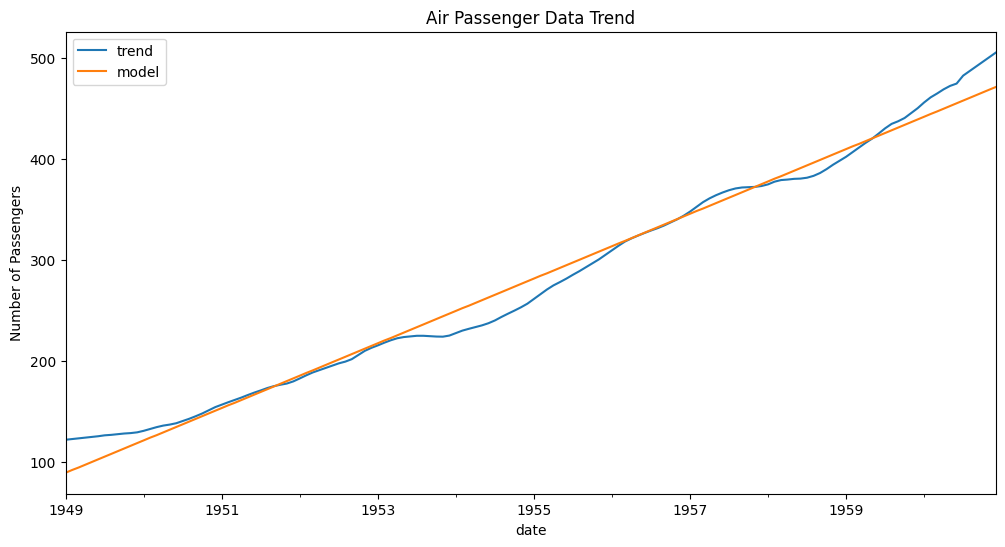

In [132]:
# visualize the fit
pd.DataFrame({'trend':air_trend,
              'model':linear_model.predict(X[['timedelta']])})\
         .plot(figsize=(12,6), title='Air Passenger Data Trend', legend=True)\
         .set_ylabel('Number of Passengers') 


In [133]:
# compute the R^2 score
dsutils.rs_score(linear_model, X[['timedelta']], y, as_string=True)

'R^2 Score: 0.99 (0.98, 0.99)'

## Seasonal Modeling

Next we build a model on the seasonal data.  We will use a **gradient boosting regression** model.

In [134]:
air_seasonal = decomp.seasonal

Text(0, 0.5, 'Seasonal Component')

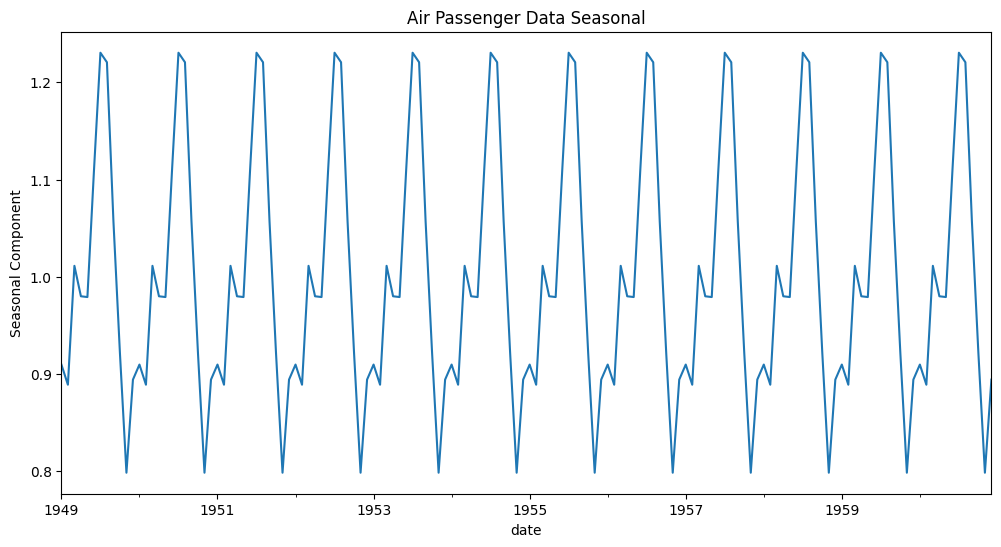

In [135]:

air_seasonal.plot(figsize=(12,6), title='Air Passenger Data Seasonal', legend=False)\
      .set_ylabel('Seasonal Component')

We can see that the seasonal period is 12 months.  We will construct a seasonal model for 1 period.

In [136]:
X_season = X[:12]
y_season = air_seasonal[:12]


In [137]:
X_season

,timedelta,month
date,,
1949-01-01,0,1
1949-02-01,31,2
1949-03-01,59,3
1949-04-01,90,4
1949-05-01,120,5
1949-06-01,151,6
1949-07-01,181,7
1949-08-01,212,8
1949-09-01,243,9


In [138]:
y_season

date
1949-01-01    0.909736
1949-02-01    0.889010
1949-03-01    1.011294
1949-04-01    0.979983
1949-05-01    0.979186
1949-06-01    1.108329
1949-07-01    1.230491
1949-08-01    1.220670
1949-09-01    1.057133
1949-10-01    0.921421
1949-11-01    0.798497
1949-12-01    0.894250
Name: seasonal, dtype: float64

### Gradient Boosting Regression

In [142]:

# fit a gradient boosting model
gbr_model = GradientBoostingRegressor().fit(X_season[['month']],y_season)


Text(0, 0.5, 'Number of Passengers')

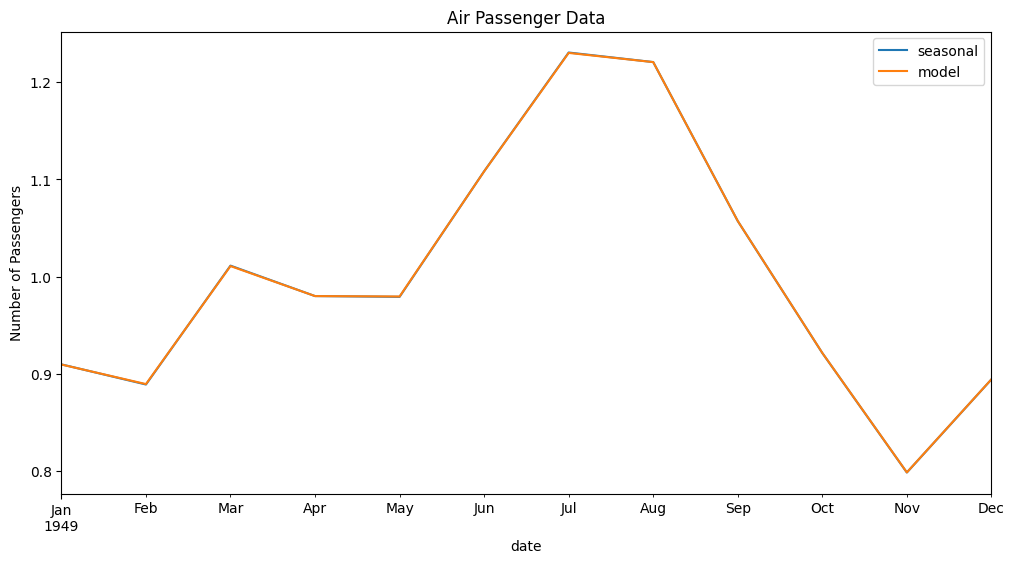

In [144]:
pd.DataFrame({'seasonal':y_season,
              'model':gbr_model.predict(X_season[['month']])})\
         .plot(figsize=(12,6), title='Air Passenger Data', legend=True)\
         .set_ylabel('Number of Passengers')

In [145]:
mean_absolute_error(y_season,gbr_model.predict(X_season[['month']]))

0.00019806587322441596

**Note**: We use mean absolute error here because the $R^2$ is almost meaningless here, it will always return something close to 1.

We could continue this, but this score is already pretty good, notice in the plot it covers the original curve almost completely.

## Forecasting Model

Our forecasting model will combine trend and the seasonal models.

In [ ]:
def predict_air_passengers(X):
    """
    Predict the number of air passengers given a timedelta and month.
    """
    # Predict the trend
    trend = linear_model.predict(X[['timedelta']])
    
    # Predict the seasonal component
    seasonal = gbr_model.predict(X[['month']])
    
    # Return the predicted number of passengers
    return trend * seasonal


Text(0, 0.5, 'Number of Passengers')

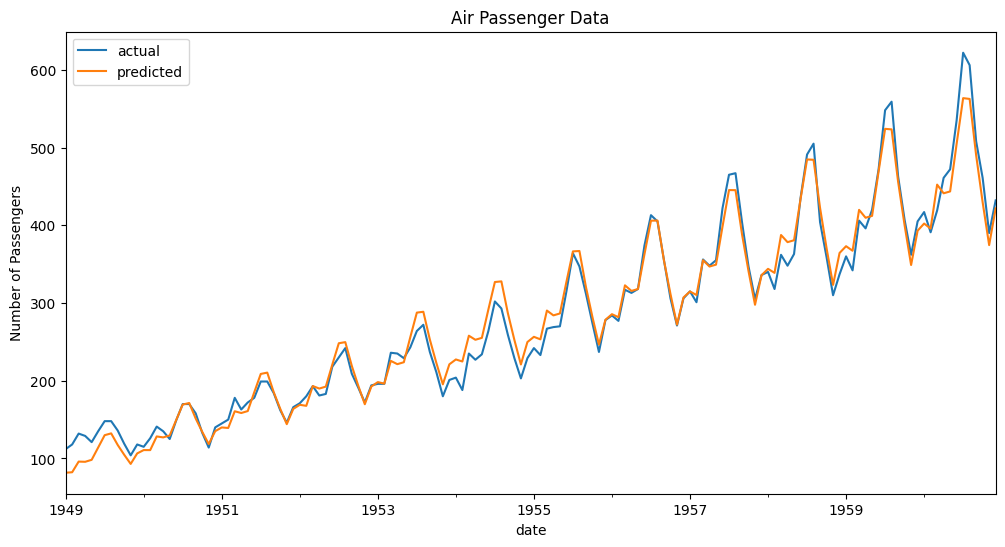

In [148]:
pd.DataFrame({'actual': air['passengers'],
              'predicted': predict_air_passengers(X)})\
          .plot(figsize=(12,6), title='Air Passenger Data', legend=True)\
          .set_ylabel('Number of Passengers')   

Forecast a date range we haven't seen yet.

In [161]:
new_index = pd.DatetimeIndex(
    pd.date_range(start='1961-01-01', end='1973-12-01', freq='MS')
)
new_index
X_new = pd.DataFrame({'timedelta': list((new_index - air.index[0]).days),
                      'month': new_index.month},
                      index=new_index)
X_new


,timedelta,month
1961-01-01,4383,1
1961-02-01,4414,2
1961-03-01,4442,3
1961-04-01,4473,4
1961-05-01,4503,5
...,...,...
1973-08-01,8978,8
1973-09-01,9009,9
1973-10-01,9039,10
1973-11-01,9070,11


Text(0, 0.5, 'Number of Passengers')

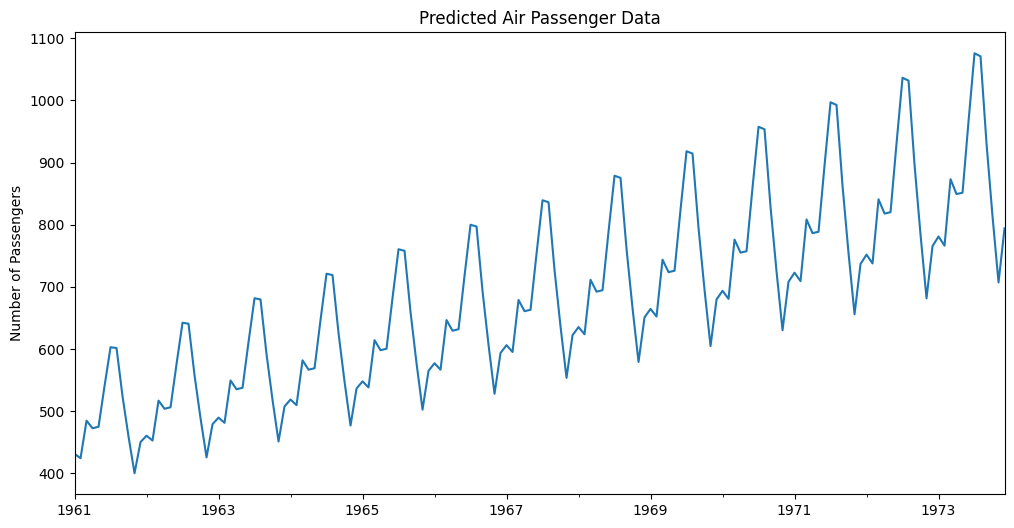

In [162]:
pd.DataFrame({'predicted': predict_air_passengers(X_new)},
             index=new_index)\
      .plot(figsize=(12,6), title='Predicted Air Passenger Data', legend=False)\
      .set_ylabel('Number of Passengers')